<a href="https://colab.research.google.com/github/Accenture-AI-Studio/fake-news/blob/main/FakeNewsDetectionwithGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Setup and Installation**

Installing required libraries for **OpenAI API** acess and data processing.

In [ ]:
!pip install openai pandas tqdm
# import libraries
!pip install rapidfuzz
!pip install datasketch
!pip install nltk
import pandas as pd
import numpy as np
import re
import os
import pickle
import nltk
from nltk.corpus import stopwords
from datasketch import MinHash, MinHashLSH
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

from google.colab import drive, files
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import re
!pip install langdetect



**2. Uploading Files**

In [ ]:
# load datasets 'True.csv' and 'Fake.csv' from google drive and concat them into a single dataframe 'df'

drive.mount('/content/drive')
for f in os.listdir():
    print(f)

df_false = pd.read_csv('/content/drive/MyDrive/Fake.csv')
df_true = pd.read_csv('/content/drive/MyDrive/True.csv')

df_false["label"] = 0
df_true["label"] = 1

df = pd.concat([df_true, df_false], axis=0).reset_index(drop=True)


df.head(5)
df.columns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
.config
drive
sample_data


Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

## Analyze & Clean Data

In [ ]:
# analyze dataframe

print(df.shape)
print("📰 True articles:")
print(df[df["label"] == 1].head(10))

print("\n🧾 False articles:")
print(df[df["label"] == 0].head(10))

(44898, 5)
📰 True articles:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   
5  White House, Congress prepare for talks on spe...   
6  Trump says Russia probe will be fair, but time...   
7  Factbox: Trump on Twitter (Dec 29) - Approval ...   
8         Trump on Twitter (Dec 28) - Global Warming   
9  Alabama official to certify Senator-elect Jone...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SE

In [ ]:
# check rows for any missing values

print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [title, text, subject, date, label]
Index: []


In [ ]:
# print the unique values & their counts for column 'subject'

subject_label_counts = df.groupby(['subject', 'label']).size()
print(subject_label_counts)

subject          label
Government News  0         1570
Middle-east      0          778
News             0         9050
US_News          0          783
left-news        0         4459
politics         0         6841
politicsNews     1        11272
worldnews        1        10145
dtype: int64


In [ ]:
# drop 'left-news' in Fake column as it doesn't have an equivalent in True columns and could learn bias

df = df[df['subject'] != 'left-news']
print(df['subject'].value_counts())

# drop 'subject' and 'date' columns as they don't carry significant information

df = df.drop(columns=['subject', 'date'])
print(df.columns.tolist())

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64
['title', 'text', 'label']


In [ ]:
# convert text in columns 'text' and 'title' to lowercase

df['text'] = df['text'].str.lower()
df['title'] = df['title'].str.lower()

In [ ]:
# find word count metrics for text and title based on label

df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
df['title_length'] = df['title'].apply(lambda x: len(str(x).split()))

print(df.groupby('label')['text_length'].describe())
print(df.groupby('label')['title_length'].describe())


         count        mean         std  min    25%    50%    75%     max
label                                                                   
0      19022.0  430.338503  417.925202  0.0  257.0  371.0  505.0  8135.0
1      21417.0  385.640099  274.006204  0.0  148.0  359.0  525.0  5172.0
         count       mean       std  min   25%   50%   75%   max
label                                                           
0      19022.0  14.190727  3.975359  1.0  12.0  14.0  16.0  42.0
1      21417.0   9.954475  1.700747  4.0   9.0  10.0  11.0  20.0


In [ ]:
# remove any articles that only contain whitespaces
df = df[df['text'].str.strip() != '']
df = df[df['title'].str.strip() != '']

In [ ]:
# remove outlier articles (based on word count)

# obtain q1 and q3 text lengths
q1_text = df['text_length'].quantile(0.25)
q3_text = df['text_length'].quantile(0.75)
iqr_text = q3_text - q1_text

q1_title = df['title_length'].quantile(0.25)
q3_title = df['title_length'].quantile(0.75)
iqr_title = q3_title - q1_title

# keep only articles within 1.5*IQR from q1 and q3
df = df[(df['text_length'] >= q1_text - 1.5*iqr_text) & (df['text_length'] <= q3_text + 1.5*iqr_text)]
df = df[(df['title_length'] >= q1_title - 1.5*iqr_title) & (df['title_length'] <= q3_title + 1.5*iqr_title)]

# remove any articles with less than 50 words in text
df = df[(df['text_length'] >= 50)]

In [ ]:
# analyze change

print(df.groupby('label')['text_length'].describe())
print(df.groupby('label')['title_length'].describe())

         count        mean         std   min    25%    50%    75%    max
label                                                                   
0      15936.0  396.744603  172.155638  50.0  292.0  377.0  493.0  969.0
1      20426.0  366.006854  232.142314  50.0  153.0  354.0  502.0  969.0
         count       mean       std  min   25%   50%   75%   max
label                                                           
0      15936.0  13.619980  3.011208  4.0  12.0  14.0  16.0  21.0
1      20426.0   9.949917  1.690636  4.0   9.0  10.0  11.0  20.0


In [ ]:
# download stopwords from library
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


# clean text function
def full_clean_text(text):
    if not isinstance(text, str):
        return ""

    # remove anything before "(Reuters) - "
    text = re.sub(r"^.*?(?:\(Reuters\)|Reuters)\s*-\s*", "", text, flags=re.IGNORECASE)

    # fix encoding artifacts
    try:
        text = text.encode('latin1').decode('utf-8')
    except:
        pass

    # remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # remove month names and numbers
    text = re.sub(
    r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec|'
    r'january|february|march|april|may|june|july|august|september|october|november|december)\b\.?',
    '',
    text,
    flags=re.IGNORECASE
    )
    text = re.sub(r'\d+', '', text)


    # remove stopwords
    words = text.split()
    words = [w for w in words if w.lower() not in stop_words]
    text = " ".join(words)

    # remove weird symbols
    text = re.sub(r'[^a-zA-Z0-9\s.,!?\'"-]', ' ', text)

    # get rid of multiple whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# apply to both text and title
df['text'] = df['text'].apply(full_clean_text)
df['title'] = df['title'].apply(full_clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# print column count prior to duplicate and near duplicate removal
print(df.shape)

# remove duplicates
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)


# break text into shingles

shingle_size = 7                    # num of words per shingle
num_perm = 256                      # num of permutations for MinHash
similarity_threshold = 0.85         # MinHash similarity threshold for near-duplicates

def get_shingles(text, k=shingle_size):
    words = text.split()
    shingles = set()
    for i in range(max(len(words) - k + 1, 1)):
        shingles.add(" ".join(words[i:i+k]))
    return shingles


# remove near duplicates
def remove_near_duplicates(df, text_column="text"):
    lsh = MinHashLSH(threshold=similarity_threshold, num_perm=num_perm)
    minhashes = {}
    for idx, text in enumerate(df[text_column]):
        shingles = get_shingles(text)
        m = MinHash(num_perm=num_perm)
        for shingle in shingles:
            m.update(shingle.encode('utf8'))
        minhashes[idx] = m
        lsh.insert(idx, m)
    to_drop = set()
    for idx, m in minhashes.items():
        if idx in to_drop:
            continue
        result = lsh.query(m)
        for j in result:
            if j != idx:
                to_drop.add(j)
    df_cleaned = df.drop(list(to_drop)).reset_index(drop=True)
    return df_cleaned


# update df to clean ver
df = remove_near_duplicates(df, text_column="text")


# print column count after duplicate and near duplicate cleaning
print(df.shape)

(36362, 5)
(34751, 5)


In [ ]:
# print current state of dataset
print("📰 True articles:")
print(df[df["label"] == 1].head(10))

print("\n🧾 False articles:")
print(df[df["label"] == 0].head(10))

📰 True articles:
                                               title  \
0  u.s. budget fight looms, republicans flip fisc...   
1  u.s. military accept transgender recruits mond...   
2  senior u.s. republican senator 'let mr. muelle...   
3  fbi russia probe helped australian diplomat ti...   
4  trump wants postal service charge 'much more' ...   
5  white house, congress prepare talks spending, ...   
6  trump says russia probe fair, timeline unclear...   
7    factbox trump twitter - approval rating, amazon   
8                     trump twitter - global warming   
9  alabama official certify senator-elect jones t...   

                                                text  label  text_length  \
0  head conservative republican faction u.s. cong...      1          749   
1  transgender people allowed first time enlist u...      1          624   
2  special counsel investigation links russia pre...      1          457   
3  trump campaign adviser george papadopoulos tol...      1   

In [ ]:
# combine text and title columns into one
df['title_and_text'] = " [TITLE] " + df['title'] + " [ARTICLE] " + df['text']

X = df['title_and_text']
y = df['label']

# drop all other columns besides 'title_and_text' and 'label'
df.drop(columns = ['title', 'text', 'text_length', 'title_length'], inplace=True)


In [ ]:
from openai import OpenAI
from google.colab import userdata
import os

api_key = userdata.get('openai_api_key')

client = OpenAI(api_key = api_key)

def classification_with_GPT(title, content):
  prompt = f"""
You are a fake news classification assistant. Classify the following news article as either TRUE or FAKE based only on the content.

Title: {title}

Article: {content}

Respond with only one word: TRUE or FAKE.
"""

  try:
    response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user", "content": prompt}],
    temperature=0,
    max_tokens=10
)
    label = response.choices[0].message.content
    return label if label in ["TRUE", "FAKE"] else "UNKNOWN"



  except Exception as e:
      print("GPT error:", e)
      return "ERROR"

In [ ]:
print(df.columns)


Index(['label', 'title_and_text'], dtype='object')


In [ ]:
#testing 1 row

row = df.sample(1).iloc[0]

prediction = classification_with_GPT("", row['title_and_text'])

print("Prediction", prediction)

Prediction FAKE


In [ ]:
sample_df = df.sample(5, random_state=123).copy()

def classify_row(row):
    return classification_with_GPT("", row['title_and_text'])

sample_df["gpt_label"] = sample_df.apply(classify_row, axis=1)

print(sample_df[['label', "gpt_label"]])

       label gpt_label
31848      0      FAKE
5509       1      TRUE
9867       1      TRUE
32993      0      FAKE
2661       1      FAKE


In [ ]:
sample_df = df.sample(1000, random_state=123).copy()

def classify_row(row):
    return classification_with_GPT("", row['title_and_text'])

sample_df["gpt_label"] = sample_df.apply(classify_row, axis=1)

print(sample_df[['label', "gpt_label"]])

       label gpt_label
31848      0      FAKE
5509       1      TRUE
9867       1      TRUE
32993      0      FAKE
2661       1      FAKE
...      ...       ...
17754      1      FAKE
29278      0      FAKE
15458      1      TRUE
8459       1      FAKE
24084      0      FAKE

[1000 rows x 2 columns]


In [ ]:
label_mapping = {0: "FAKE", 1: "TRUE"}
y_true_str = sample_df["label"].map(label_mapping)
y_pred = sample_df["gpt_label"]

# Accuracy score
accuracy = accuracy_score(y_true_str, y_pred)
print(f"Accuracy: {accuracy:.2%}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_str, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true_str, y_pred))

Accuracy: 76.50%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.65      0.97      0.78       429
        TRUE       0.96      0.61      0.75       571

    accuracy                           0.77      1000
   macro avg       0.81      0.79      0.76      1000
weighted avg       0.83      0.77      0.76      1000


Confusion Matrix:
[[414  15]
 [220 351]]


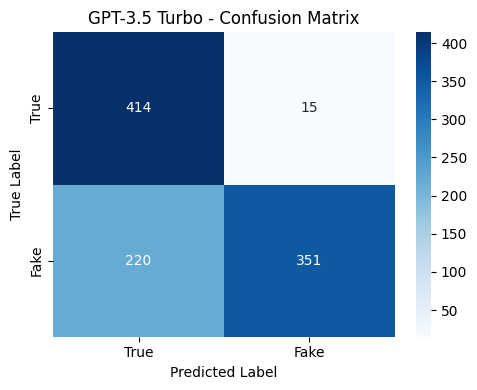

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_str, y_pred)
labels = ["True", "Fake"]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels,
            cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("GPT-3.5 Turbo - Confusion Matrix")

plt.tight_layout()
plt.show()



In [ ]:

def classification_reasoning(title, content):
    prompt = f"""
You are a fake-news classification assistant. Evaluate the following article and give 0–100 scores for each aspect
before deciding if it’s REAL or FAKE.

Title: {title}

Article: {content}

For each category, give a number 0–100:
- Source credibility
- Dramatic language (invert: 0 = very dramatic, 100 = neutral)
- Factual detail and specificity
- Verifiability (can it be cross-checked)

Then provide a final decision and final score as the average.

Respond in this format:
CREDIBILITY: [0-100]
LANGUAGE: [0-100]
DETAIL: [0-100]
VERIFIABILITY: [0-100]
FINAL SCORE: [0-100]
LABEL: [REAL or FAKE]
REASON: [short explanation]
"""

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=250
        )

        output = response.choices[0].message.content.strip()

        # Use regex to extract values
        nums = re.findall(r":\s*([0-9]+)", output)
        scores = list(map(int, nums[:5])) if len(nums) >= 5 else [0, 0, 0, 0, 0]
        avg_score = sum(scores[:4]) / 4 if len(scores) >= 4 else scores[0]

        label_match = re.search(r"LABEL:\s*(REAL|FAKE)", output, re.IGNORECASE)
        reason_match = re.search(r"REASON:\s*(.*)", output, re.IGNORECASE)

        label = label_match.group(1).upper() if label_match else "UNKNOWN"
        reason = reason_match.group(1).strip() if reason_match else ""

        return label, avg_score, reason

    except Exception as e:
        print("GPT error:", e)
        return "ERROR", None, ""


In [ ]:
sample_df = df.sample(1000, random_state=123).copy()

def classify_res(row):
    return classification_reasoning("", row['title_and_text'])

results = sample_df.apply(classify_res, axis=1, result_type="expand")
sample_df[["gpt_label", "trust_score", "reason"]] = results

# Show results
print(sample_df[["label", "gpt_label", "trust_score", "reason"]])

       label gpt_label  trust_score  \
31848      0      FAKE        32.50   
5509       1      REAL        67.50   
9867       1      REAL        65.00   
32993      0      FAKE        31.25   
2661       1      REAL        65.00   
...      ...       ...          ...   
17754      1      REAL        57.50   
29278      0      FAKE        40.00   
15458      1      REAL        70.00   
8459       1      REAL        65.00   
24084      0      FAKE        37.50   

                                                  reason  
31848  The article lacks credibility as it does not p...  
5509   The article provides specific details about th...  
9867   The article discusses a real event involving t...  
32993  The article lacks credibility, factual detail,...  
2661   The article provides specific details and quot...  
...                                                  ...  
17754  The article provides some specific details and...  
29278  The article lacks credibility as it uses drama...  


In [ ]:
valid_df = sample_df[sample_df["gpt_label"].isin(["REAL", "FAKE"])].copy()
y_true = valid_df["label"]
y_pred = valid_df["gpt_label"].map({"REAL": 1, "FAKE": 0})


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy:  {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall:    {recall:.2%}")
print(f"F1 Score:  {f1:.2%}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Accuracy:  89.30%
Precision: 86.48%
Recall:    96.32%
F1 Score:  91.14%

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       429
           1       0.86      0.96      0.91       571

    accuracy                           0.89      1000
   macro avg       0.90      0.88      0.89      1000
weighted avg       0.90      0.89      0.89      1000


Confusion Matrix:
[[343  86]
 [ 21 550]]


In [ ]:
pd.set_option("display.max_colwidth", None)

print(sample_df["reason"])


31848                                                                    The article lacks credibility as it does not provide reliable sources for the polling data mentioned. The language is dramatic, and the lack of verifiability makes it difficult to trust the information presented.
5509                                                                   The article provides specific details about the U.S. immigration order and quotes from government officials, making it credible and verifiable. The language used is neutral and factual, with a good level of detail.
9867                                The article discusses a real event involving the U.S. and Canada's relationship and their discussions on various issues. The language is neutral and the details provided are fairly specific, but some claims may need to be cross-checked for accuracy.
32993                                                                                                                              The article

In [ ]:
from sklearn.metrics import roc_curve, auc

# Convert labels to numeric
y_true = sample_df["label"]
y_pred = sample_df["gpt_label"].map({"FAKE": 0, "REAL": 1})
y_score_gpt = sample_df["trust_score"] / 100.0

# Compute ROC points and AUC
fpr_gpt, tpr_gpt, _ = roc_curve(y_true, y_score_gpt)
roc_auc_gpt = auc(fpr_gpt, tpr_gpt)

print(f"AUC for GPT: {roc_auc_gpt:.2f}")






AUC for GPT: 0.95


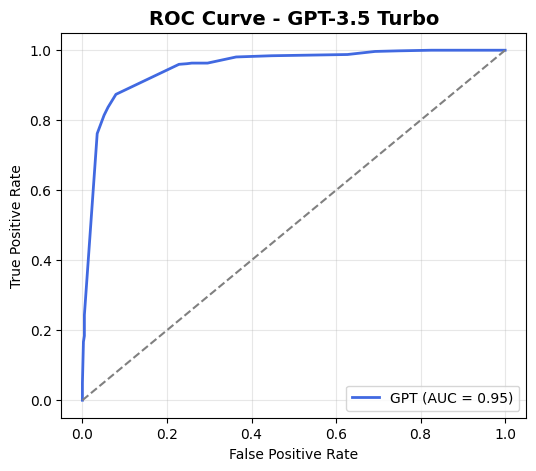

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))

# Plot GPT curve
plt.plot(fpr_gpt, tpr_gpt, color="royalblue", lw=2,
         label=f"GPT (AUC = {roc_auc_gpt:.2f})")

# Add diagonal line for random guessing
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Labels and title
plt.title("ROC Curve - GPT-3.5 Turbo", fontsize=14, fontweight="bold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()


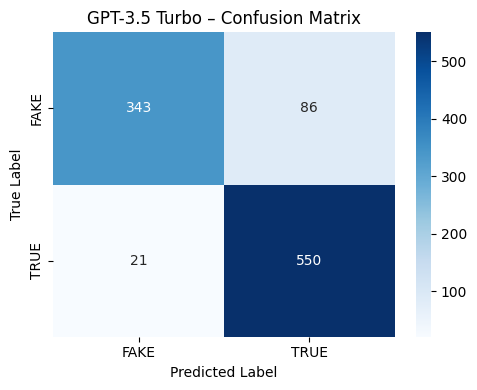

In [ ]:


# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Label order: 0 = FAKE, 1 = TRUE
labels = ["FAKE", "TRUE"]

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("GPT-3.5 Turbo – Confusion Matrix")
plt.tight_layout()
plt.show()

